# Feature selection ;)

In [1]:
import pickle
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sksurv.preprocessing import OneHotEncoder as SurvOneHotEncoder
from sksurv.util import Surv

from sksurv.column import encode_categorical
from sksurv.column import standardize
from sksurv.util import Surv

from sklearn.model_selection import train_test_split
from sksurv.ensemble import RandomSurvivalForest
from sksurv.linear_model import CoxnetSurvivalAnalysis


In [2]:
from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
)

def evaluate_model_uno_c(model, test_X, test_y, train_y, times):
    pred = model.predict(test_X)
    uno_concordance = concordance_index_ipcw(train_y, test_y, pred, tau=times[-1])
    return uno_concordance

def evaluate_model(model, test_X, test_y, train_y, times):
    pred = model.predict(test_X)
    surv_fn = model.predict_survival_function(test_X, return_array=False)
    surv_prob = np.row_stack([fn(times) for fn in surv_fn])

    uno_concordance = concordance_index_ipcw(train_y, test_y, pred, tau=times[-1])
    ibs = integrated_brier_score(train_y, test_y, surv_prob, times)
    auc, mean_auc = cumulative_dynamic_auc(train_y, test_y, pred, times)

    print(f"Concordance Uno: {round(uno_concordance[0], 3)}")
    print(f"IBS: {round(ibs, 3)}")
    print(f"Mean AUC: {round(mean_auc,3)}")

    return uno_concordance, ibs, mean_auc

In [3]:
# pickle_file = 'data/COX_DATA_FULL_LIVING.pkl'
pickle_file = 'data/COX_DATA_FULL_LIVING_EXPERIMENTAL.pkl'

with open(pickle_file, 'rb') as f:
    dataset = pickle.load(f)

dataset.drop(['DIAG_KI', 'COD_KI'], axis=1, inplace=True)

In [4]:
dataset.shape

(53082, 58)

In [5]:
yes_categorical=["PRE_TX_TXFUS", 
                "GENDER",
                "ON_DIALYSIS", 
                "ABO_MAT", 
                "ETHCAT", 
                "ETHCAT_DON",
                'HBV_CORE', 
                'DIAB',
                'HCV_SEROSTATUS',  
                'LIV_DON_TY',
            ]
yes_numerical = [   
                "SERUM_CREAT",
                "NPKID", 
                "AGE", 
                "HGT_CM_CALC", 
                "BMI_DON_CALC",
                "AGE_DON",
                "DIALYSIS_TIME",      
                ]

In [6]:
dataset[yes_numerical] = dataset[yes_numerical].astype(float)

dataset[yes_numerical].dtypes

SERUM_CREAT      float64
NPKID            float64
AGE              float64
HGT_CM_CALC      float64
BMI_DON_CALC     float64
AGE_DON          float64
DIALYSIS_TIME    float64
dtype: object

In [7]:
numeric_features = [x for x in yes_numerical if x != "PTIME" and x != "PSTATUS"]

def preprocess_data(feature_importance):
    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('encoder', OneHotEncoder(handle_unknown='ignore')) # maybe it's better to use not ignore
    ])
    preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, yes_numerical),
                ('cat', categorical_transformer, yes_categorical)
            ]
        )

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor)
    ])

    if feature_importance:
        categorical_x = encode_categorical(dataset[yes_categorical])
        numerical_x = standardize(dataset[yes_numerical])
        X = pd.concat([numerical_x, categorical_x], axis=1)
    else:
        X = pipeline.fit_transform(dataset[yes_categorical + yes_numerical])
    
    survival_time = dataset["PTIME"].astype(np.float64)
    event = dataset["PSTATUS"].astype(float).astype(bool)
    y = Surv.from_arrays(event, survival_time, "Status", "Days")

    return X, y


X, y = preprocess_data(True)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y["Status"], random_state=42)

In [9]:
from tqdm._tqdm_notebook import tqdm
import numpy as np
from sklearn.model_selection import KFold, GridSearchCV

lower, upper = np.percentile(y["Days"], [10, 90])
times = np.arange(lower, upper + 1)

cox = CoxnetSurvivalAnalysis(l1_ratio=0.9, max_iter=1000)
cox.fit(X_train, y_train)

estimated_alphas = cox.alphas_

cv = KFold(n_splits=5, shuffle=True, random_state=0)
gcv = GridSearchCV(
    CoxnetSurvivalAnalysis(l1_ratio=0.9),
    param_grid={"alphas": [[v] for v in estimated_alphas]},
    cv=cv,
    error_score=0.5,
    n_jobs=-1,
).fit(X_train, y_train)

cv_results = pd.DataFrame(gcv.cv_results_)

/var/folders/c7/7_0s689j2m99wkwqx2b0skvm0000gn/T/ipykernel_65536/1667922982.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm
/Users/kyrylo/anaconda3/envs/kidney-life/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:729: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
/Users/kyrylo/anaconda3/envs/kidney-life/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:729: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)


In [10]:
best_params = gcv.best_params_

coxnet_pred = CoxnetSurvivalAnalysis(l1_ratio=0.9, alphas=[best_params['alphas'][0]], fit_baseline_model=True)
coxnet_pred.fit(X_train, y_train)
_,_,_ = evaluate_model(coxnet_pred, X_test, y_test, y_train, times)

Concordance Uno: 0.723
IBS: 0.136
Mean AUC: 0.743


In [11]:
prediction = coxnet_pred.predict(X_test)

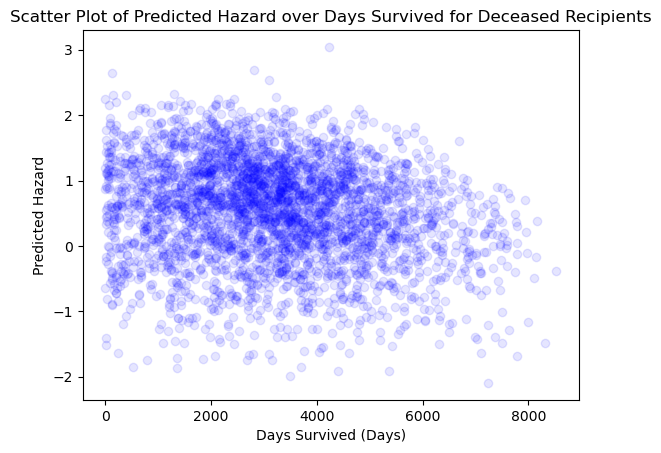

In [19]:
import matplotlib.pyplot as plt

prediction = coxnet_pred.predict(X_test)

true_data = y_test[y_test['Status']]

# Extract the "Days" and "Prediction" values from the filtered data
days_true = true_data['Days']
prediction_true = prediction[y_test['Status']]

# Plot the filtered data
plt.scatter(days_true, prediction_true, color='blue', alpha=0.1)
plt.xlabel('Days Survived (Days)')
plt.ylabel('Predicted Hazard')
plt.title('Scatter Plot of Predicted Hazard over Days Survived for Deceased Recipients')
path = "../Thesis/Images/Results/"
plt.savefig(path + "scoring.pdf", bbox_inches="tight")
plt.show()

In [13]:
import pandas as pd

# Assuming y_test[Days] and prediction are numpy arrays
df = pd.DataFrame({'y_test[Days]': days_true, 'prediction': prediction_true})

df_sorted = df.sort_values(by='y_test[Days]')
df_sorted

,y_test[Days],prediction
2745,0.0,0.875078
3029,2.0,-0.650834
955,2.0,2.241477
3128,2.0,1.185931
1056,4.0,0.335481
...,...,...
2755,8096.0,-0.494503
374,8145.0,-0.166048
2504,8158.0,0.378297
749,8321.0,-1.491615


In [14]:
sfs=coxnet_pred.predict_survival_function(X_test)

In [15]:
def plot_survival_function(survival_function, x_line=None):
    """
    Plot survival function predicted by scikit-survival.

    Parameters:
    survival_predictions : array-like
        Predicted survival probabilities.
    time : array-like
        Time points corresponding to the survival predictions.

    Returns:
    None
    """
    plt.figure(figsize=(8, 6))
    plt.step(survival_function.x, survival_function.y, where="post", alpha=0.5)
    if x_line is not None:
        plt.axvline(x=x_line, color='r', linestyle='--')
    plt.xlabel("Time")
    plt.ylabel("Survival Probability")
    plt.title("Survival Function")
    plt.grid(True)
    # plt.show()

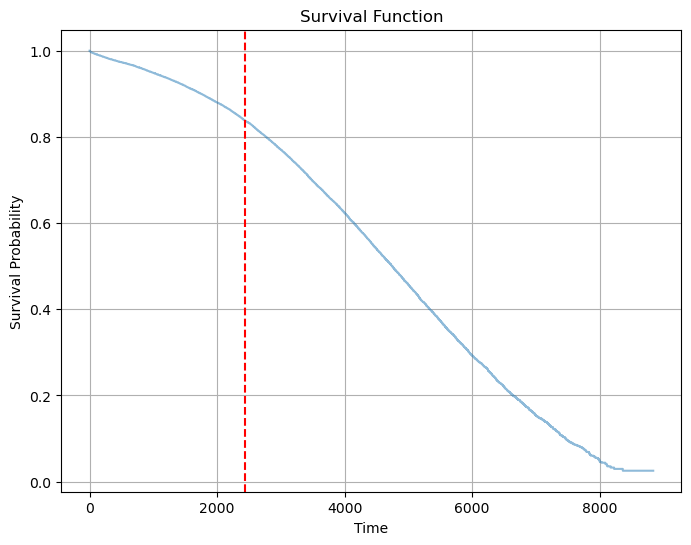

In [16]:
plot_survival_function(sfs[0], y_test[0]['Days'])

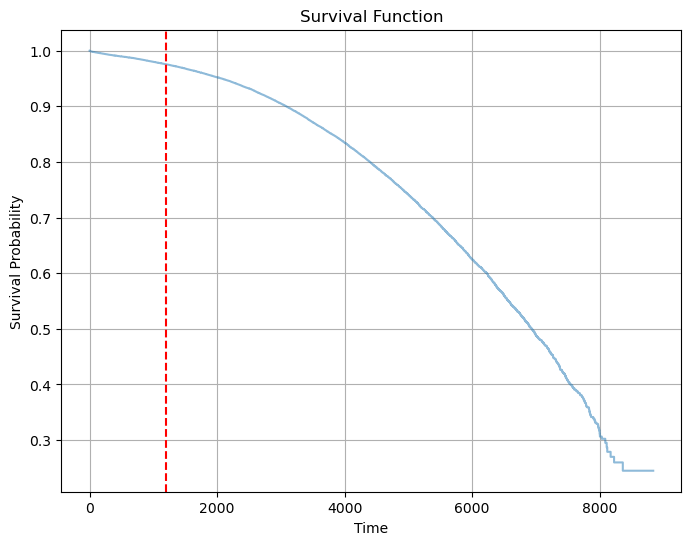

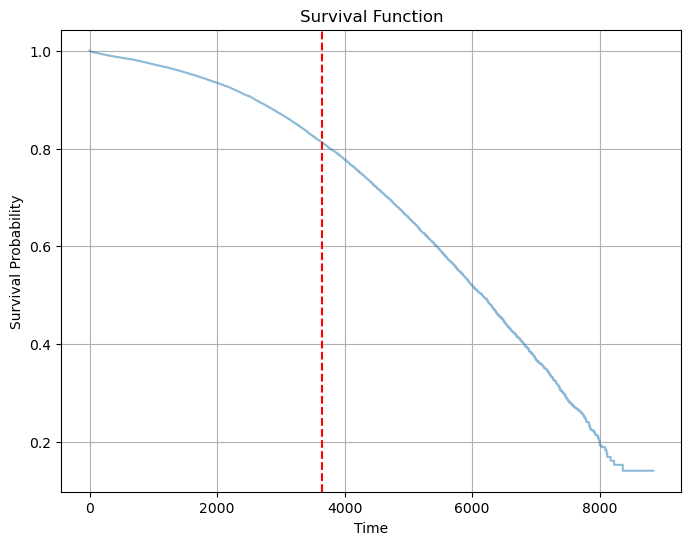

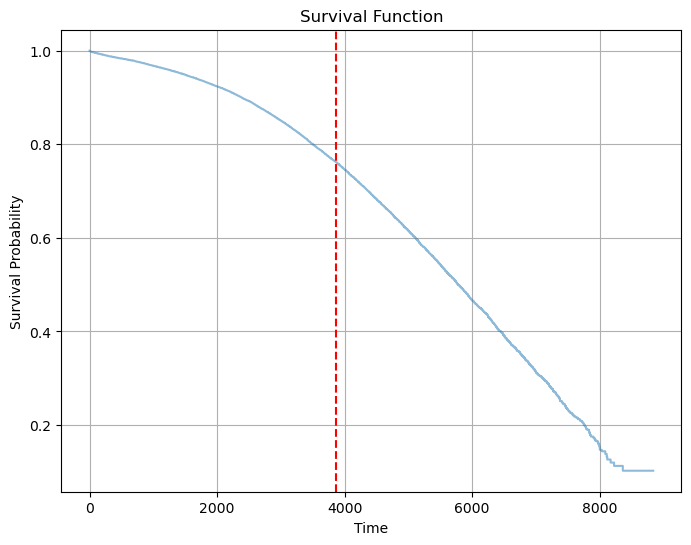

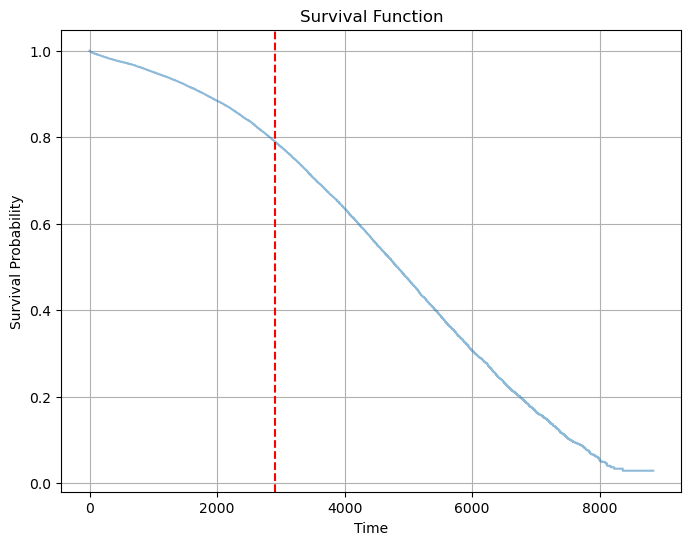

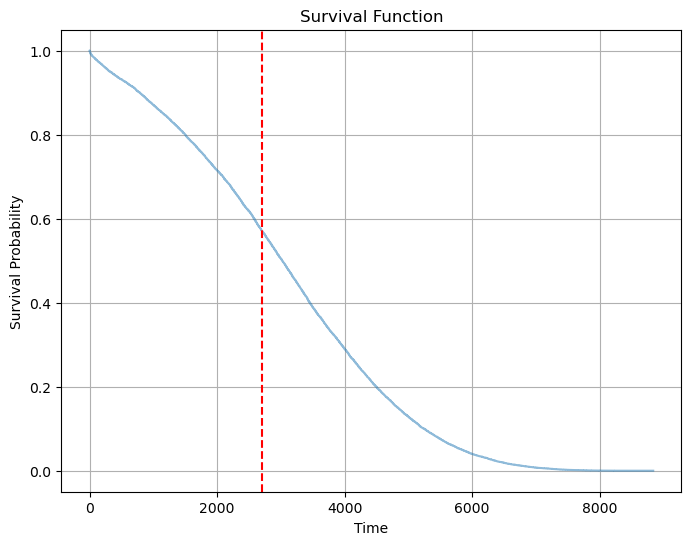

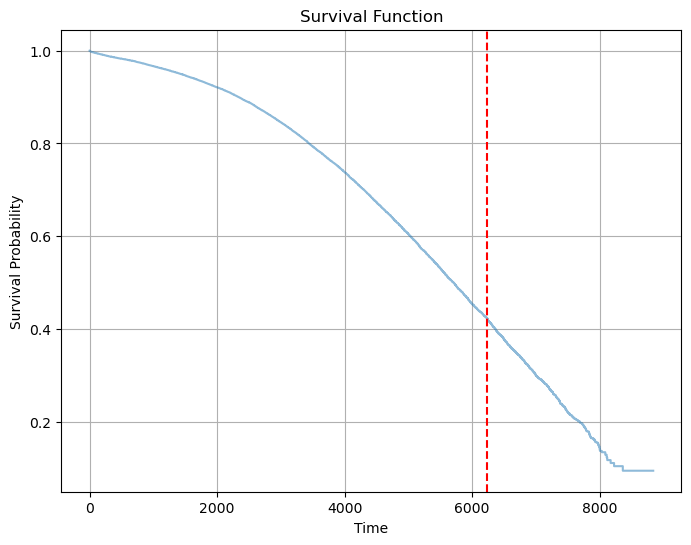

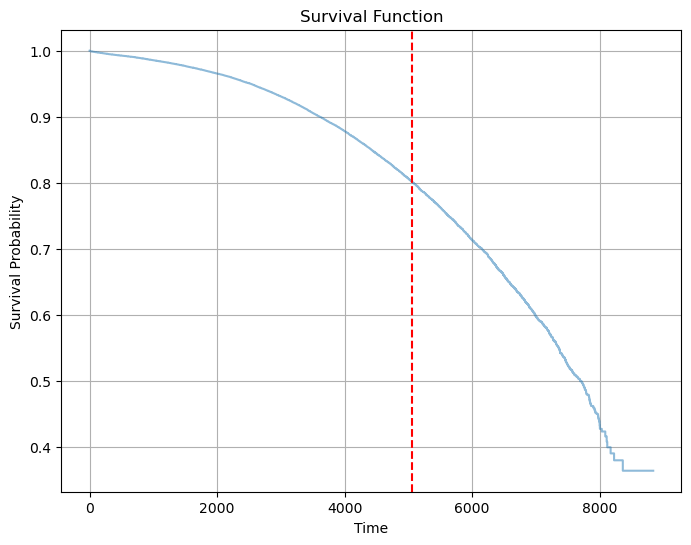

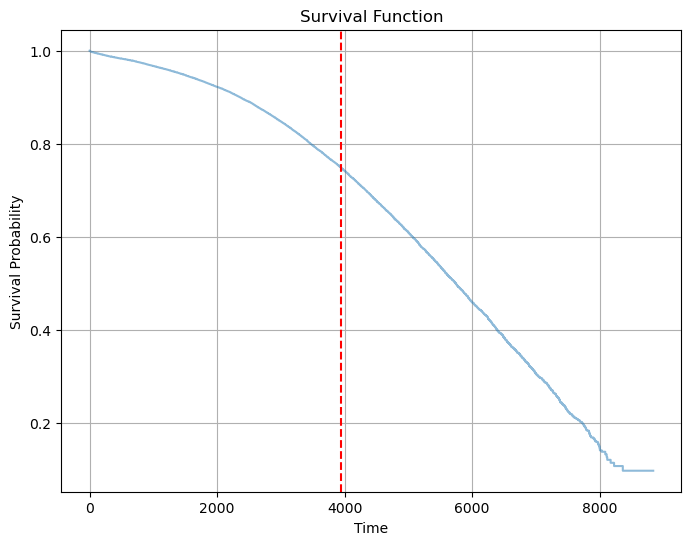

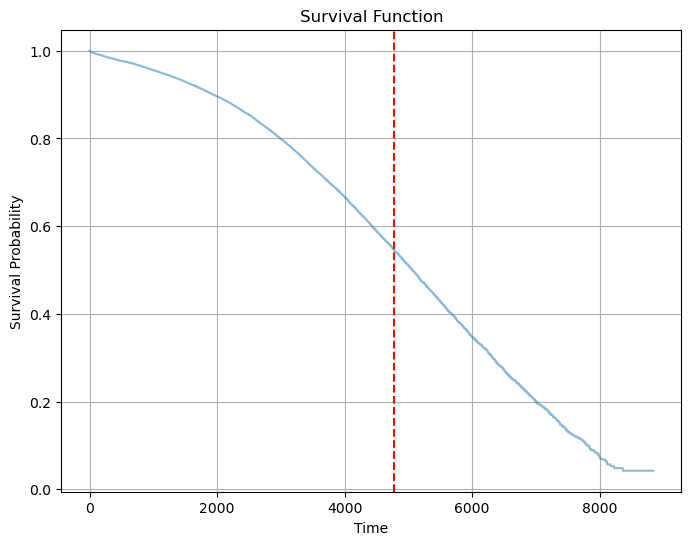

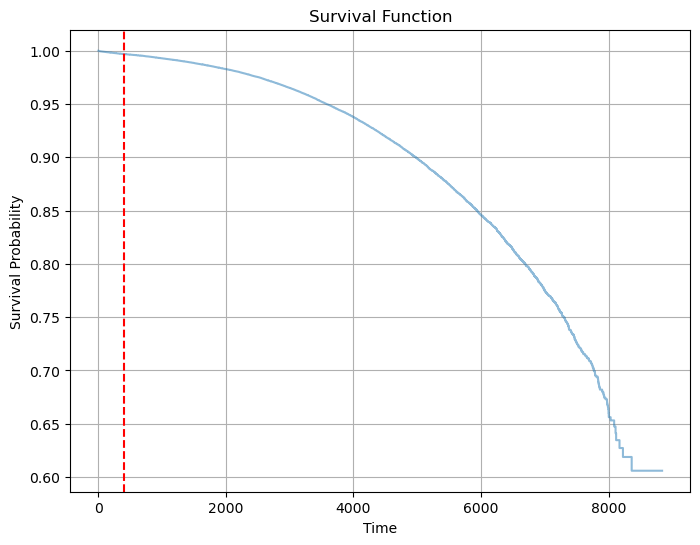

In [17]:
# fig, axes = plt.subplots(9, 9, figsize=(18, 18))
for i in range(10, 20):
    plot_survival_function(sfs[i], y_test[i]['Days'])

# plt.tight_layout()
plt.show()